# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. [LangGraph](https://langchain-ai.github.io/langgraph/) is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain its benefits, show how to use it to build workflows / agents, and show how it works with [LangChain](https://www.langchain.com/) / [LangSmith](https://docs.smith.langchain.com/).

![ecosystem](img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat interface that takes a list of messages as input and returns a message as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1", temperature=0)

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: Synchronously process inputs and return outputs
- `stream()`: Return outputs [incrementally](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they're generated

In [3]:
result = llm.invoke("What is LangGraph?")

In [4]:
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content='**LangGraph** is an open-source framework designed for building stateful, multi-agent applications powered by Large Language Models (LLMs). It extends the popular [LangChain](https://www.langchain.com/) ecosystem, focusing on enabling complex workflows where multiple agents (LLMs, tools, or humans) interact in a graph-like structure.\n\n### Key Features\n\n- **Graph-based Workflows:**  \n  LangGraph lets you define workflows as graphs, where each node can be an agent, a tool, or a function, and edges represent possible transitions based on state or output.\n- **Stateful Interactions:**  \n  Unlike simple chains, LangGraph maintains and updates a shared state as the workflow progresses, allowing for memory, context, and iterative reasoning.\n- **Multi-Agent Collaboration:**  \n  Easily orchestrate multiple agents that can communicate, collaborate, or debate to solve complex tasks.\n- **Flexible Control Flow:**  \n  Supports loops, branching, and conditional logic, mak

In [6]:
result.content

'**LangGraph** is an open-source framework designed for building stateful, multi-agent applications powered by Large Language Models (LLMs). It extends the popular [LangChain](https://www.langchain.com/) ecosystem, focusing on enabling complex workflows where multiple agents (LLMs, tools, or humans) interact in a graph-like structure.\n\n### Key Features\n\n- **Graph-based Workflows:**  \n  LangGraph lets you define workflows as graphs, where each node can be an agent, a tool, or a function, and edges represent possible transitions based on state or output.\n- **Stateful Interactions:**  \n  Unlike simple chains, LangGraph maintains and updates a shared state as the workflow progresses, allowing for memory, context, and iterative reasoning.\n- **Multi-Agent Collaboration:**  \n  Easily orchestrate multiple agents that can communicate, collaborate, or debate to solve complex tasks.\n- **Flexible Control Flow:**  \n  Supports loops, branching, and conditional logic, making it suitable fo

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

In [4]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [5]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [6]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [7]:
write_email.description

'Write and send an email.'

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

Note that we use the [`tool_choice` parameter](https://python.langchain.com/docs/how_to/tool_choice/) to enforce tool calling.

In [8]:
# Connect tools to a chat model
model_with_tools = llm.bind_tools([write_email], tool_choice="required")

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss about tomorrow's meeting")

In [9]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args']
args

{'to': "[Boss's Email]",
 'subject': "Re: Tomorrow's Meeting",
 'content': "Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I confirm my attendance and will be prepared with the necessary updates and materials.\n\nPlease let me know if there is anything specific you would like me to focus on or bring to the discussion.\n\nBest regards,\n[Your Name]"}

In [10]:
# Call the tool
result = write_email.invoke(args)
print(result)  # "Email to boss@company.com drafted with subject 'Re: Meeting Tomorrow'"

Email sent to [Boss's Email] with subject 'Re: Tomorrow's Meeting' and content: Dear [Boss's Name],

Thank you for the reminder about tomorrow's meeting. I confirm my attendance and will be prepared with the necessary updates and materials.

Please let me know if there is anything specific you would like me to focus on or bring to the discussion.

Best regards,
[Your Name]


Above, we enforce tool calling by setting `tool_choice="required"`, so the model will always call a tool to write an email.

![basic_prompt](img/tool_call.png)

## Workflows
 
There are many patterns for building applications with LLMs. 

[We can embed LLM calls into pre-defined workflows](https://langchain-ai.github.io/langgraph/tutorials/workflows/), giving the system more agency to make decisions. 

As an example, we could add a router step to determine whether to write an email or not.

![workflow_example](img/workflow_example.png)

## Agents

We can further increase agency, allowing the LLM to dynamically direct its own tool usage. 

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/) are typically implemented as tool calling in a loop, where the output of each tool call is used to inform the next action.

![agent_example](img/agent_example.png)

Agents are well suited to open-ended problems where it's difficult to predict the *exact* steps needed in advance.
 
Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. 

It does not abstract prompts or architecture, and provides a few benefits:

- **Control**: Make it easy to define and / or combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- **Testing, Debugging, and Deployment**: Provide an easy onramp for testing, debugging, and deploying applications.

### Control

LangGraph lets you define your application as a graph with:

1. *State*: What information do we need to track over the course of the application?
2. *Nodes*: How do we want to update this information over the course of the application?
3. *Edges*: How do we want to connect these nodes together?

We can use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to initialize a LangGraph graph with a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

`State` defines the schema for information we want to track over the course of the application. 

This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object. 

In [14]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

Each node is simply a python function or typescript code. This gives us full control over the logic inside each node.

They receive the current state, and return a dictionary to update the state.

By default, [state keys are overwritten](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/). 

However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). 

![nodes_edges](img/nodes_edges.png)

In [15]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email}

Edges connect nodes together. 

We specify the control flow by adding edges and nodes to our state graph. 

In [32]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

In [25]:
app.invoke({"request": "Draft a response to my boss about tomorrow's meeting"})

{'request': "Draft a response to my boss about tomorrow's meeting",
 'email': "Email sent to boss@example.com with subject 'Re: Tomorrow's Meeting' and content: Hi [Boss's Name],\n\nI hope this message finds you well. I am writing to confirm my attendance at tomorrow's meeting. Please let me know if there are any specific topics or materials you would like me to prepare in advance.\n\nLooking forward to our discussion.\n\nBest regards,\n\n[Your Name]"}

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

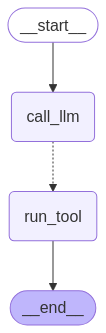

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}

def run_tool(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", END]:
    """Route to tool handler, or end if Done tool called"""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

try:
    # The API for mermaid diagrams has been unstable, so we can fallback to pyppeteer to draw the diagram
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    import nest_asyncio
    nest_asyncio.apply()
    from langchain_core.runnables.graph import MermaidDrawMethod
    display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [32]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss about tomorrow's meeting"}]})
result["messages"]

[HumanMessage(content="Draft a response to my boss about tomorrow's meeting", additional_kwargs={}, response_metadata={}, id='5e2d9fe3-c075-47ba-a253-f06ffb67aab5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_iIS382COCMtqYtfwIfBBf8P9', 'function': {'arguments': '{"to":"boss@example.com","subject":"Re: Tomorrow\'s Meeting","content":"Hi [Boss\'s Name],\\n\\nI hope this message finds you well. I am writing to confirm my attendance at tomorrow\'s meeting. Please let me know if there are any specific topics or materials you would like me to prepare in advance.\\n\\nLooking forward to our discussion.\\n\\nBest regards,\\n\\n[Your Name]"}', 'name': 'write_email'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 61, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': 

With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

In [36]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=model,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided."  
)

# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss about tomorrow's meeting"}]}
)

{'messages': [HumanMessage(content="Draft a response to my boss about tomorrow's meeting", additional_kwargs={}, response_metadata={}, id='b38b8654-8947-4f76-9d33-a3c30bb1ad1f'),
  AIMessage(content='Of course! Could you please provide a bit more detail? For example:\n\n- What is the purpose or topic of the meeting?\n- Do you want to confirm your attendance, ask to reschedule, or provide any specific information?\n- Is there a particular tone you’d like (formal, friendly, etc.)?\n\nLet me know so I can tailor the response to your needs!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 71, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_cf18407276', 'id': 'chatcmpl-BUJdSwIfBhV1zKy9CFF

### Persistence

It can be very useful to allow agents to pause and gather human feedback.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution.

![checkpointer](img/checkpoints.png)


In [41]:
from langgraph.checkpoint.memory import InMemorySaver

agent = create_react_agent(
    model=model,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {"configurable": {"thread_id": "1"}}
result = agent.invoke({"messages": [{"role": "user", "content": "What are some good practices for writing emails?"}]}, config)
                    

In [43]:
# Get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
state = agent.get_state(config)
for message in state.values['messages']:
    message.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, using the recipient’s name if possible.

3. **Be Concise and to the Point:** State your purpose early and keep your message focused.

4. **Use Proper Grammar and Spelling:** Proofread your email to avoid errors and maintain professionalism.

5. **Structure Your Email:** Use short paragraphs, bullet points, or numbered lists for clarity.

6. **Be Polite and Professional:** Use courteous language and avoid slang or overly casual expressions.

7. **Include a Call to Action:** Clearly state what you need from the recipient, if applicable.

8. **Sign Of

In [44]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "Good, let's use lesson 3 to craft a response to my boss about tomorrow's meeting"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, using the recipient’s name if possible.

3. **Be Concise and to the Point:** State your purpose early and keep your message focused.

4. **Use Proper Grammar and Spelling:** Proofread your email to avoid errors and maintain professionalism.

5. **Structure Your Email:** Use short paragraphs, bullet points, or numbered lists for clarity.

6. **Be Polite and Professional:** Use courteous language and avoid slang or overly casual expressions.

7. **Include a Call to Action:** Clearly state what you need from the recipient, if applicable.

8. **Sign Of

In [45]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "I like this, let's write the email"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, using the recipient’s name if possible.

3. **Be Concise and to the Point:** State your purpose early and keep your message focused.

4. **Use Proper Grammar and Spelling:** Proofread your email to avoid errors and maintain professionalism.

5. **Structure Your Email:** Use short paragraphs, bullet points, or numbered lists for clarity.

6. **Be Polite and Professional:** Use courteous language and avoid slang or overly casual expressions.

7. **Include a Call to Action:** Clearly state what you need from the recipient, if applicable.

8. **Sign Of

### Testing, Debugging, and Deployment

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

In [ ]:
_set_env("LANGSMITH_TRACING")
_set_env("LANGSMITH_API_KEY")

Here is the LangSmith trace from above graph execution:

https://smith.langchain.com/public/6f77014f-d054-44ed-aa2c-8b06ceab689f/r

We can see that the agent is able to continue the conversation from the previous state because we used a checkpointer.

It's also easy to deploy to deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── my_agent # all project code lies within here
│   └── agent.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to deploy a LangGraph application.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph101.py:app",
```

There are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/). 

* All create an API [server](https://langchain-ai.github.io/langgraph/concepts/langgraph_server/) for our graph
* All include an interactive IDE (LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/)).
 
We can start a deployment locally using `langgraph dev`:

In [ ]:
! langgraph dev

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)